In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


GPU: Tesla T4
Memory: 15.83 GB


# Configuration

In [ ]:

class Config:

    # Model architecture
    n_layer = 12          # Number of transformer blocks
    n_head = 8            # Number of attention heads
    n_embd = 768          # Embedding dimension

    # Training
    block_size = 128      # Context length
    batch_size = 128      # Batch size
    learning_rate = 1e-4
    max_iters = 6000
    eval_interval = 100
    eval_iters = 10

    # Regularization
    dropout = 0.3 # Randomly dropping 30 percent of neurons connections during training to prevent overfitting

    # Generation
    max_new_tokens = 200
    temperature = 0.8 # Controls randomness of predictions
    top_k = 40 # Sample from top 40 most likely tokens

    device = device

config = Config()
print(f"Model: {config.n_layer} layers, {config.n_head} heads, {config.n_embd} dimensions, batch size {config.batch_size}")


Model: 12 layers, 8 heads, 768 dimensions, batch size 128


# Data loading

In [7]:
data_path = "/content/drive/MyDrive/shakespeare.txt"

with open(data_path, "r", encoding="utf-8") as f:
    text = f.read()

print(f"Loaded {len(text):,} characters")

Loaded 1,115,394 characters


# Dataset Class (Tokenization)

In [ ]:

class CharDataset(Dataset):

    def __init__(self, config, data, stoi=None, itos=None):
        if stoi is None or itos is None:
            chars = sorted(list(set(data)))
            stoi = {ch: i for i, ch in enumerate(chars)} # char to index
            itos = {i: ch for i, ch in enumerate(chars)} # index to char

        self.stoi = stoi
        self.itos = itos
        self.block_size = config.block_size
        self.vocab_size = len(self.stoi)
        self.data = data

    def get_vocab_size(self):
        return self.vocab_size

    def get_block_size(self):
        return self.block_size

    def __len__(self):
        return len(self.data) - self.block_size 

    def __getitem__(self, idx):
        # grab a chunk of characters from the data
        chunk = self.data[idx: idx + self.block_size + 1]
        # encode every character to an integer using the shared stoi
        dix = [self.stoi[s] for s in chunk]
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y


# Split into train and validation

In [ ]:
# Build a shared vocabulary once
chars = sorted(list(set(text)))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(stoi)
print(f"Built vocab of size: {vocab_size}")

n = int(0.9 * len(text)) # first 90% will be train, rest val
train_data = text[:n]
val_data = text[n:]

train_dataset = CharDataset(config, train_data, stoi=stoi, itos=itos)
val_dataset   = CharDataset(config, val_data,   stoi=stoi, itos=itos)

assert train_dataset.get_vocab_size() == len(stoi)
assert val_dataset.get_vocab_size()   == len(stoi)
print("Train sequences:", len(train_dataset))
print("Val sequences:  ", len(val_dataset))


Built vocab of size: 65
Train sequences: 1003726
Val sequences:   111412


# Causal Self-Attention (Multi-head masked self-attention)



In [ ]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # Key, query, value projections for all heads. Wq, Wk, Wv concatenated together
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)

        # Regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        self.n_head = config.n_head
        self.n_embd = config.n_embd

        # Causal mask
        self.register_buffer(
            "mask",
            torch.tril(torch.ones(config.block_size, config.block_size))
                 .view(1, 1, config.block_size, config.block_size)
        )

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dimension
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2) # x @ [Wq; Wk; Wv]
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y


#  MLP & Transformer Block

In [11]:
# Feedforward network with GELU activation.
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        # Prenormalization
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


# Complete model (decoder only transformer)

In [12]:
class GPT(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        self.block_size = config.block_size
        self.config = config

        # Token embedding table
        self.wte = nn.Embedding(vocab_size, config.n_embd)
        # Position embedding table
        self.wpe = nn.Embedding(config.block_size, config.n_embd)
        self.drop = nn.Dropout(config.dropout)

        # Transformer blocks
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])

        # Final layer norm
        self.ln_f = nn.LayerNorm(config.n_embd)

        # Language model head
        self.lm_head = nn.Linear(config.n_embd, vocab_size, bias=False)

        # Initializing weights
        self.apply(self._init_weights)

        # Number of parameters
        n_params = sum(p.numel() for p in self.parameters())
        print(f"Number of parameters: {n_params/1e6:.2f}M")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        B, T = idx.size()
        assert T <= self.block_size, f"Sequence length {T} exceeds block size {self.block_size}"

        # Position indices
        pos = torch.arange(0, T, dtype=torch.long, device=device).unsqueeze(0)

        # Token embeddings plus position embeddings
        tok_emb = self.wte(idx)
        pos_emb = self.wpe(pos)
        x = self.drop(tok_emb + pos_emb)

        # Apply transformer blocks
        x = self.blocks(x)

        # Final layer norm
        x = self.ln_f(x)

        # Language model head
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]

            # Forward pass
            logits, _ = self(idx_cond)

            # Get logits for last position and scale by temperature
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # Applying softmax to get probabilities
            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


# Training utilities

In [13]:
# Generating a random batch of data
def get_batch(dataset, batch_size, device):
    ix = torch.randint(len(dataset), (batch_size,))
    x_list, y_list = [], []
    for i in ix:
        x, y = dataset[i]
        x_list.append(x)
        y_list.append(y)
    x = torch.stack(x_list).to(device)
    y = torch.stack(y_list).to(device)
    return x, y

# Estimate loss over multiple batches
@torch.no_grad()
def estimate_loss(model, train_dataset, val_dataset, config):
    model.eval()
    out = {}

    for split, dataset in [('train', train_dataset), ('val', val_dataset)]:
        losses = []
        for _ in range(config.eval_iters):
            X, Y = get_batch(dataset, config.batch_size, config.device)
            logits, loss = model(X, Y)
            losses.append(loss.item())
        out[split] = sum(losses) / len(losses)

    model.train()
    return out


# Create Model

In [14]:
model = GPT(config, train_dataset.get_vocab_size())
model = model.to(config.device)
print(f"Model moved to {config.device}")
print("\nExample characters in vocabulary:")
print(''.join(list(train_dataset.stoi.keys())[:50]))

Number of parameters: 85.25M
Model moved to cuda

Example characters in vocabulary:

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijk


# Training Loop

In [15]:
def train(model, train_dataset, val_dataset, config):

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
    train_losses = []
    val_losses = []
    steps = []
    best_val_loss = float('inf')
    best_step = 0

    model.train()
    for iter in range(config.max_iters):
        # Sample a batch
        xb, yb = get_batch(train_dataset, config.batch_size, config.device)

        # Forward pass
        logits, loss = model(xb, yb)

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update weights
        optimizer.step()

        # Evaluation and logging
        if iter % config.eval_interval == 0 or iter == config.max_iters - 1:
            losses = estimate_loss(model, train_dataset, val_dataset, config)

            # Calculating perplexity
            train_ppl = math.exp(losses['train'])
            val_ppl = math.exp(losses['val'])
            steps.append(iter)
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(f"Step {iter:4d} , "
                  f"Train Loss: {losses['train']:.4f} (PPL: {train_ppl:6.2f}) , "
                  f"Val Loss: {losses['val']:.4f} (PPL: {val_ppl:6.2f})")

            if losses['val'] < best_val_loss:
                best_val_loss = losses['val']
                best_step = iter
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'config': config,
                    'stoi': train_dataset.stoi,
                    'itos': train_dataset.itos,
                    'iter': iter,
                    'best_val_loss': best_val_loss,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'steps': steps,
                }, '/content/drive/MyDrive/best_model.pt')


    print(f"Training completed: {config.max_iters} steps")
    print(f"Best validation loss: {best_val_loss:.4f} at step {best_step}")
    print(f"Final validation loss: {val_losses[-1]:.4f} at step {config.max_iters-1}")

    return train_losses, val_losses, steps

train_losses, val_losses, steps = train(
    model, train_dataset, val_dataset, config
)

Step    0 , Train Loss: 4.3806 (PPL:  79.89) , Val Loss: 4.4504 (PPL:  85.66)
Step  100 , Train Loss: 2.4860 (PPL:  12.01) , Val Loss: 2.4897 (PPL:  12.06)
Step  200 , Train Loss: 2.3675 (PPL:  10.67) , Val Loss: 2.3957 (PPL:  10.98)
Step  300 , Train Loss: 2.1751 (PPL:   8.80) , Val Loss: 2.2033 (PPL:   9.06)
Step  400 , Train Loss: 2.0235 (PPL:   7.56) , Val Loss: 2.1007 (PPL:   8.17)
Step  500 , Train Loss: 1.8844 (PPL:   6.58) , Val Loss: 2.0069 (PPL:   7.44)
Step  600 , Train Loss: 1.7857 (PPL:   5.96) , Val Loss: 1.9271 (PPL:   6.87)
Step  700 , Train Loss: 1.7000 (PPL:   5.47) , Val Loss: 1.8545 (PPL:   6.39)
Step  800 , Train Loss: 1.6455 (PPL:   5.18) , Val Loss: 1.8146 (PPL:   6.14)
Step  900 , Train Loss: 1.5825 (PPL:   4.87) , Val Loss: 1.7636 (PPL:   5.83)
Step 1000 , Train Loss: 1.5432 (PPL:   4.68) , Val Loss: 1.7422 (PPL:   5.71)
Step 1100 , Train Loss: 1.4930 (PPL:   4.45) , Val Loss: 1.7003 (PPL:   5.48)
Step 1200 , Train Loss: 1.4743 (PPL:   4.37) , Val Loss: 1.6710 

In [7]:
best_checkpoint = torch.load('/content/drive/MyDrive/best_model.pt', weights_only=False)
model.load_state_dict(best_checkpoint['model_state_dict'])

model.eval()

seeds = ["O God, O God!"]

for seed in seeds:
    print(f"Seed: '{seed}'")

    # Encode context
    context_idx = torch.tensor(
        [train_dataset.stoi[s] for s in seed],
        dtype=torch.long,
        device=config.device
    ).unsqueeze(0)

    generated_idx = model.generate(
        context_idx,
        max_new_tokens=config.max_new_tokens,
        temperature=config.temperature,
        top_k=config.top_k
    )

    # Decode
    generated_text = ''.join([train_dataset.itos[int(i)] for i in generated_idx[0]])
    print(generated_text)

Seed: 'O God, O God!'
O God, O God! 'Judgm, all my words and blood
Is dishonourable steps, for a white Edward's daughter
Will be content of the devil.

DUKE OF YORK:
So that bid me not, my lord,
And therefore he is my son's lies, shall


# Save Model

In [18]:
save_path = '/content/drive/MyDrive/shakespeare_gpt.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'stoi': train_dataset.stoi,
    'itos': train_dataset.itos,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'steps': steps,
}, save_path)

print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final val loss: {val_losses[-1]:.4f}")

Final train loss: 0.8159
Final val loss: 1.6025


# Final Visualization

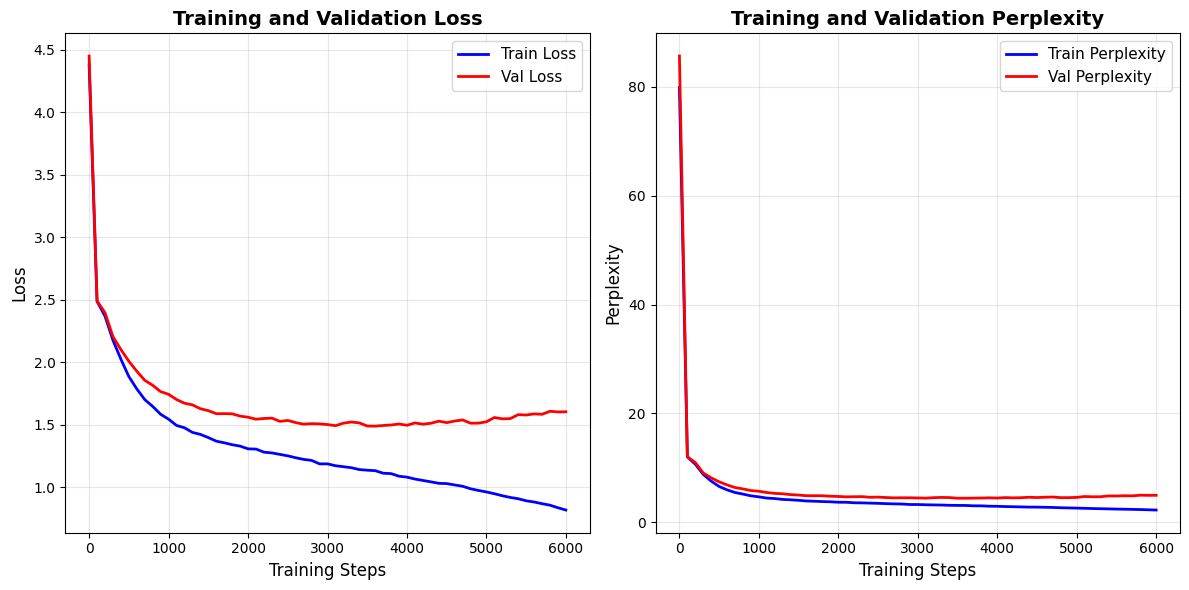

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(steps, train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(steps, val_losses, 'r-', label='Val Loss', linewidth=2)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
train_ppl = [math.exp(l) for l in train_losses]
val_ppl = [math.exp(l) for l in val_losses]
plt.plot(steps, train_ppl, 'b-', label='Train Perplexity', linewidth=2)
plt.plot(steps, val_ppl, 'r-', label='Val Perplexity', linewidth=2)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Perplexity', fontsize=12)
plt.title('Training and Validation Perplexity', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
